<a href="https://colab.research.google.com/github/Navikasrikanth/Physic-Informed-Neural-Network/blob/main/Copy_of_Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Define Poisson’s Equation and Boundary Conditions
We are solving the **2D Poisson equation**:

Δu(x, y) = f(x, y),   for (x, y) ∈ [0,1] × [0,1]

Boundary conditions:
u(x, y) = 0,   for (x, y) on the boundary (Dirichlet BC).

Here, Δ is the Laplace operator.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

POLY_TYPE = "sin(pi*x)*sin(pi*y)"
ACTIVATION = "Tanh"
LEARNING_RATE = 5e-4
NOISE_LEVEL = 0.0
N_F = 20000
N_B = 800
EPOCHS_FORWARD = 3000
EPOCHS_INVERSE = 5000
PRINT_EVERY = 100

print("Architecture: Fully-connected MLP (2 -> 50 -> 50 -> 1)")
print("Solution type:", POLY_TYPE)
print("Activation:", ACTIVATION)
print("Learning rate:", LEARNING_RATE)
print("Noise level:", NOISE_LEVEL)
print("Collocation points (interior):", N_F)
print("Boundary points:", N_B)
print("Epochs (forward):", EPOCHS_FORWARD, "Epochs (inverse):", EPOCHS_INVERSE)
print("Device:", device)



Architecture: Fully-connected MLP (2 -> 50 -> 50 -> 1)
Solution type: sin(pi*x)*sin(pi*y)
Activation: Tanh
Learning rate: 0.0005
Noise level: 0.0
Collocation points (interior): 20000
Boundary points: 800
Epochs (forward): 3000 Epochs (inverse): 5000
Device: cuda


###Generate Forward Problem Data

In this step, we set up the data for the forward problem:

- We define the exact solution `u(x, y)` as `A * sin(pi*x) * sin(pi*y)`.
- The source function `f(x, y)` is defined as `-2 * pi^2 * A * sin(pi*x) * sin(pi*y)`.
- The boundary function `g(x, y)` gives the values of `u` on the edges of the domain.

Next, we generate:

- **Interior collocation points** randomly inside the square domain.
- **Boundary points** along the edges of the domain.
- **Boundary values** using the boundary function.
- Optionally, we can add noise to the boundary values.




In [ ]:
A_true = 1.0

def u_exact_func(x, y, A=A_true):
  return A * torch.sin(np.pi * x) * torch.sin(np.pi * y)

def f_forward_func(x, y, A=A_true):
  return -2 * (np.pi**2) * A * torch.sin(np.pi * x) * torch.sin(np.pi * y)

def g_boundary(x, y, A=A_true):
  return u_exact_func(x, y, A=A)

x_f = torch.rand(N_F, 1, device=device) #compute collocation points
y_f = torch.rand(N_F, 1, device=device)

n_edge = N_B // 4
x_b = torch.cat([                #combine all boundary points
torch.rand(n_edge,1),
torch.zeros(n_edge,1),
torch.ones(n_edge,1),
torch.rand(n_edge,1)
], dim=0).to(device)
y_b = torch.cat([
torch.zeros(n_edge,1),
torch.rand(n_edge,1),
torch.rand(n_edge,1),
torch.ones(n_edge,1)
], dim=0).to(device)

u_b = g_boundary(x_b, y_b).to(device)        #store exact solution of boundary points to find boundary loss later
if NOISE_LEVEL > 0:
  u_b = u_b + NOISE_LEVEL * torch.randn_like(u_b)


# Define Neural Network

In this step, we define a simple fully connected neural network with:

- Input: two values (x and y)
- Two hidden layers with a specified number of neurons (default 50) and Tanh activation
- Output: single value u(x, y)
- Xavier initialization for all linear layer weights and zero initialization for biases


## **Xavier (Glorot) Initialization**
Xavier initialization (also called Glorot initialization) is a way to set the initial weights of a neural network so that signals flow properly through the layers at the start of training.


When training neural networks, how we initialize weights matters.  
- If weights are **too small** → activations and gradients vanish.  
- If weights are **too large** → activations and gradients explode.  


**Xavier initialization** (Glorot & Bengio, 2010) balances this by keeping the variance of activations roughly the same across all layers.


In [ ]:
class PINN(nn.Module):
  def __init__(self, hidden_dim=100, activation=nn.Tanh):
    super().__init__()
    self.fc1 = nn.Linear(2, hidden_dim)
    self.act1 = activation()
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.act2 = activation()
    self.fc3 = nn.Linear(hidden_dim, 1)
    # Xavier init
    nn.init.xavier_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
    nn.init.xavier_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
    nn.init.xavier_normal_(self.fc3.weight); nn.init.zeros_(self.fc3.bias)

  def forward(self, x, y):             #moving forward by using activation function through each layer till output
    inp = torch.cat([x, y], dim=1)
    z = self.act1(self.fc1(inp))
    z = self.act2(self.fc2(z))
    out = self.fc3(z)
    return out

model = PINN(hidden_dim=100, activation=nn.Tanh).to(device)      #Instantiates the network with 100 neurons per
                                                                 # hidden layer and Tanh activation and moves it to gpu
print(model)

PINN(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)


# Define Loss Function

In this step, we define how the model will be trained:

- Compute the Laplacian (second derivatives) of the predicted u(x, y) using automatic differentiation.
- Compute the PDE residual loss at interior collocation points.
- Compute the boundary loss at boundary points.
- Total loss = PDE residual loss + boundary loss
- Return both the total loss and individual losses for monitoring.


In [ ]:
mse_loss = nn.MSELoss()

def laplacian_u(model, x, y):
  x_req = x.clone().detach().requires_grad_(True)
  y_req = y.clone().detach().requires_grad_(True)
  u = model(x_req, y_req)
  grad_u = torch.autograd.grad(u, [x_req, y_req], grad_outputs=torch.ones_like(u), create_graph=True)
  u_x = grad_u[0]
  u_y = grad_u[1]
  u_xx = torch.autograd.grad(u_x, x_req, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y_req, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
  return u_xx + u_yy

def pinn_loss_forward(model, x_f, y_f, x_b, y_b, u_b):
  f_pred = laplacian_u(model, x_f, y_f)
  f_true = f_forward_func(x_f, y_f).to(device)
  loss_f = mse_loss(f_pred, f_true)
  u_b_pred = model(x_b, y_b)
  loss_b = mse_loss(u_b_pred, u_b)
  return loss_f + loss_b, loss_f.item(), loss_b.item()

# Train the Forward PINN

In this step, we train the neural network to solve the Poisson equation:

- Use the Adam optimizer with a specified learning rate.
- For each epoch:
  - Compute the total loss using the `pinn_loss_forward` function.
  - Perform backpropagation and update the model parameters.
  - Periodically print the total loss, PDE residual loss, and boundary loss to monitor training progress.


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print("Starting forward training...")
for epoch in range(1, EPOCHS_FORWARD + 1):
  model.train()
  optimizer.zero_grad()
  total_loss, loss_f_val, loss_b_val = pinn_loss_forward(model, x_f, y_f, x_b, y_b, u_b)
  total_loss.backward()
  optimizer.step()
  if epoch % PRINT_EVERY == 0 or epoch == 1 or epoch == EPOCHS_FORWARD:
    print(f"[Forward] Epoch {epoch}/{EPOCHS_FORWARD}  Total Loss: {total_loss.item():.6e} "
          f"Residual Loss: {loss_f_val:.6e} Boundary Loss: {loss_b_val:.6e}")

Starting forward training...
[Forward] Epoch 1/3000  Total Loss: 9.835143e+01 Residual Loss: 9.829612e+01 Boundary Loss: 5.531398e-02
[Forward] Epoch 100/3000  Total Loss: 2.661763e+01 Residual Loss: 2.321815e+01 Boundary Loss: 3.399479e+00
[Forward] Epoch 200/3000  Total Loss: 5.964535e+00 Residual Loss: 5.759179e+00 Boundary Loss: 2.053561e-01
[Forward] Epoch 300/3000  Total Loss: 2.636856e+00 Residual Loss: 2.310637e+00 Boundary Loss: 3.262193e-01
[Forward] Epoch 400/3000  Total Loss: 1.669532e+00 Residual Loss: 1.329861e+00 Boundary Loss: 3.396707e-01
[Forward] Epoch 500/3000  Total Loss: 1.053519e+00 Residual Loss: 8.283254e-01 Boundary Loss: 2.251931e-01
[Forward] Epoch 600/3000  Total Loss: 2.655681e-01 Residual Loss: 2.262550e-01 Boundary Loss: 3.931312e-02
[Forward] Epoch 700/3000  Total Loss: 8.604940e-02 Residual Loss: 6.605007e-02 Boundary Loss: 1.999933e-02
[Forward] Epoch 800/3000  Total Loss: 5.884311e-02 Residual Loss: 4.226781e-02 Boundary Loss: 1.657529e-02
[Forward] 

###Train the Inverse PINN

In this step, we train a neural network to **discover an unknown parameter** (alpha) in the PDE:

- We create a new PINN model and define `alpha` as a trainable parameter.
- The source function now depends on `alpha`.
- Loss is computed similar to the forward problem: PDE residual + boundary loss.
- Both the model parameters and `alpha` are updated using Adam optimizer.
- We monitor training by printing total loss, residual loss, boundary loss, and the current value of `alpha`.


In [ ]:
alpha = torch.tensor(0.8, requires_grad=True, device=device)
model_inv = PINN(hidden_dim=100, activation=nn.Tanh).to(device)
params_inv = list(model_inv.parameters()) + [alpha]
optimizer_inv = optim.Adam(params_inv, lr=LEARNING_RATE)

def f_inverse_func(x, y, alpha_param):
  return -2 * (np.pi**2) * alpha_param * torch.sin(np.pi * x) * torch.sin(np.pi * y)

def pinn_loss_inverse(model, alpha_param, x_f, y_f, x_b, y_b, u_b):
  x_req = x_f.clone().detach().requires_grad_(True)
  y_req = y_f.clone().detach().requires_grad_(True)
  u = model(x_req, y_req)
  grad_u = torch.autograd.grad(u, [x_req, y_req], grad_outputs=torch.ones_like(u), create_graph=True)
  u_x = grad_u[0]; u_y = grad_u[1]
  u_xx = torch.autograd.grad(u_x, x_req, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
  u_yy = torch.autograd.grad(u_y, y_req, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
  f_pred = u_xx + u_yy
  f_true = f_inverse_func(x_f, y_f, alpha_param)
  loss_f = mse_loss(f_pred, f_true)
  u_b_pred = model(x_b, y_b)
  loss_b = mse_loss(u_b_pred, u_b)
  return loss_f + loss_b, loss_f.item(), loss_b.item()

print("Starting inverse training...")
for epoch in range(1, EPOCHS_INVERSE + 1):
  model_inv.train()
  optimizer_inv.zero_grad()
  total_loss_inv, loss_f_inv, loss_b_inv = pinn_loss_inverse(model_inv, alpha, x_f, y_f, x_b, y_b, u_b)
  total_loss_inv.backward()
  optimizer_inv.step()
  if epoch % PRINT_EVERY == 0 or epoch == 1 or epoch == EPOCHS_INVERSE:
    print(f"[Inverse] Epoch {epoch}/{EPOCHS_INVERSE}  Total Loss: {total_loss_inv.item():.6e} "
          f"Residual Loss: {loss_f_inv:.6e} Boundary Loss: {loss_b_inv:.6e}  alpha={alpha.item():.6f}")

Starting inverse training...
[Inverse] Epoch 1/5000  Total Loss: 6.342275e+01 Residual Loss: 6.342263e+01 Boundary Loss: 1.184700e-04  alpha=0.799500
[Inverse] Epoch 100/5000  Total Loss: 1.251290e+01 Residual Loss: 1.128564e+01 Boundary Loss: 1.227263e+00  alpha=0.756648
[Inverse] Epoch 200/5000  Total Loss: 3.959124e+00 Residual Loss: 3.853559e+00 Boundary Loss: 1.055652e-01  alpha=0.745387
[Inverse] Epoch 300/5000  Total Loss: 1.919996e+00 Residual Loss: 1.772747e+00 Boundary Loss: 1.472481e-01  alpha=0.739301
[Inverse] Epoch 400/5000  Total Loss: 8.969697e-01 Residual Loss: 7.410673e-01 Boundary Loss: 1.559024e-01  alpha=0.735557
[Inverse] Epoch 500/5000  Total Loss: 7.278252e-01 Residual Loss: 6.073674e-01 Boundary Loss: 1.204577e-01  alpha=0.733275
[Inverse] Epoch 600/5000  Total Loss: 3.537183e-01 Residual Loss: 2.864117e-01 Boundary Loss: 6.730667e-02  alpha=0.731426
[Inverse] Epoch 700/5000  Total Loss: 1.175281e-01 Residual Loss: 9.384635e-02 Boundary Loss: 2.368178e-02  alph

###Predict Solutions for Forward and Inverse Problems

In this step, we:

- Generate a grid of points in the domain for testing.
- Use the trained **forward model** to predict u(x, y) across the domain.
- Use the trained **inverse model** to predict u(x, y) and recover the learned parameter alpha.
- Store the exact solution for comparison.


In [ ]:
n_test = 50
x_vals = torch.linspace(0,1,n_test, device=device).reshape(-1,1)
y_vals = torch.linspace(0,1,n_test, device=device).reshape(-1,1)
Xg, Yg = torch.meshgrid(x_vals.squeeze(), y_vals.squeeze(), indexing="ij")
xg_flat = Xg.reshape(-1,1)
yg_flat = Yg.reshape(-1,1)

model.eval()
with torch.no_grad():
  u_pred_forward = model(xg_flat, yg_flat).cpu()
  u_exact_all = u_exact_func(xg_flat.cpu(), yg_flat.cpu(), A=A_true)

model_inv.eval()
with torch.no_grad():
  u_pred_inverse = model_inv(xg_flat, yg_flat).cpu()
  u_exact_inv = u_exact_func(xg_flat.cpu(), yg_flat.cpu(), A=A_true)
  learned_alpha = alpha.item()

# **RESULTS VISUALISATION**

## Compute Metrics and Show Sample Predictions

In this step, we evaluate the performance of the forward and inverse PINN models:

- Compute **Mean Squared Error (MSE)** between predicted and exact solutions.
- Compute **Relative L2 Error**.
- Compute approximate **accuracy** as a percentage.
- Print the **learned parameter alpha** from the inverse problem.
- Display a few **sample predictions** from both forward and inverse models alongside the exact values.


In [ ]:
def compute_metrics(u_pred, u_exact):
  diff = u_pred - u_exact
  mse = torch.mean(diff**2).item()
  rel_l2 = (torch.norm(diff) / torch.norm(u_exact)).item()
  acc_percent = max(0.0, (1 - rel_l2) * 100)
  return mse, rel_l2, acc_percent

mse_fwd, rel_fwd, acc_fwd = compute_metrics(u_pred_forward, u_exact_all)
mse_inv, rel_inv, acc_inv = compute_metrics(u_pred_inverse, u_exact_all)

print("\n--- Forward-trained model metrics ---")
print("MSE:", mse_fwd)
print("Relative L2 Error:", rel_fwd)
print(f"Accuracy (approx): {acc_fwd:.2f}%")

print("\n--- Inverse-trained model metrics ---")
print("MSE:", mse_inv)
print("Relative L2 Error:", rel_inv)
print(f"Accuracy (approx): {acc_inv:.2f}%")
print("Learned alpha (inverse):", learned_alpha)
print("True amplitude A_true:", A_true)

print("\nSample predictions (forward model):")
for i in range(5):
  print(f"x={xg_flat[i].item():.3f}, y={yg_flat[i].item():.3f}, u_pred={u_pred_forward[i].item():.6f}, u_exact={u_exact_all[i].item():.6f}")
print("\nSample predictions (inverse model):")
for i in range(5):
  print(f"x={xg_flat[i].item():.3f}, y={yg_flat[i].item():.3f}, u_pred={u_pred_inverse[i].item():.6f}, u_exact={u_exact_inv[i].item():.6f}")


--- Forward-trained model metrics ---
MSE: 0.001566954655572772
Relative L2 Error: 0.08078527450561523
Accuracy (approx): 91.92%

--- Inverse-trained model metrics ---
MSE: 0.01638885773718357
Relative L2 Error: 0.26126325130462646
Accuracy (approx): 73.87%
Learned alpha (inverse): 0.726817786693573
True amplitude A_true: 1.0

Sample predictions (forward model):
x=0.000, y=0.000, u_pred=-0.124599, u_exact=0.000000
x=0.000, y=0.020, u_pred=-0.112743, u_exact=0.000000
x=0.000, y=0.041, u_pred=-0.101014, u_exact=0.000000
x=0.000, y=0.061, u_pred=-0.089439, u_exact=0.000000
x=0.000, y=0.082, u_pred=-0.078044, u_exact=0.000000

Sample predictions (inverse model):
x=0.000, y=0.000, u_pred=-0.036035, u_exact=0.000000
x=0.000, y=0.020, u_pred=-0.031143, u_exact=0.000000
x=0.000, y=0.041, u_pred=-0.026441, u_exact=0.000000
x=0.000, y=0.061, u_pred=-0.021942, u_exact=0.000000
x=0.000, y=0.082, u_pred=-0.017661, u_exact=0.000000


##Visualize Predictions and Errors

In this step, we plot heatmaps to visually compare the forward and inverse PINN predictions against the exact solution:

- First row: forward problem
  - Predicted solution
  - Exact solution
  - Absolute error
- Second row: inverse problem
  - Predicted solution
  - Exact solution
  - Absolute error

This helps to see where the model is accurate and where errors are larger.


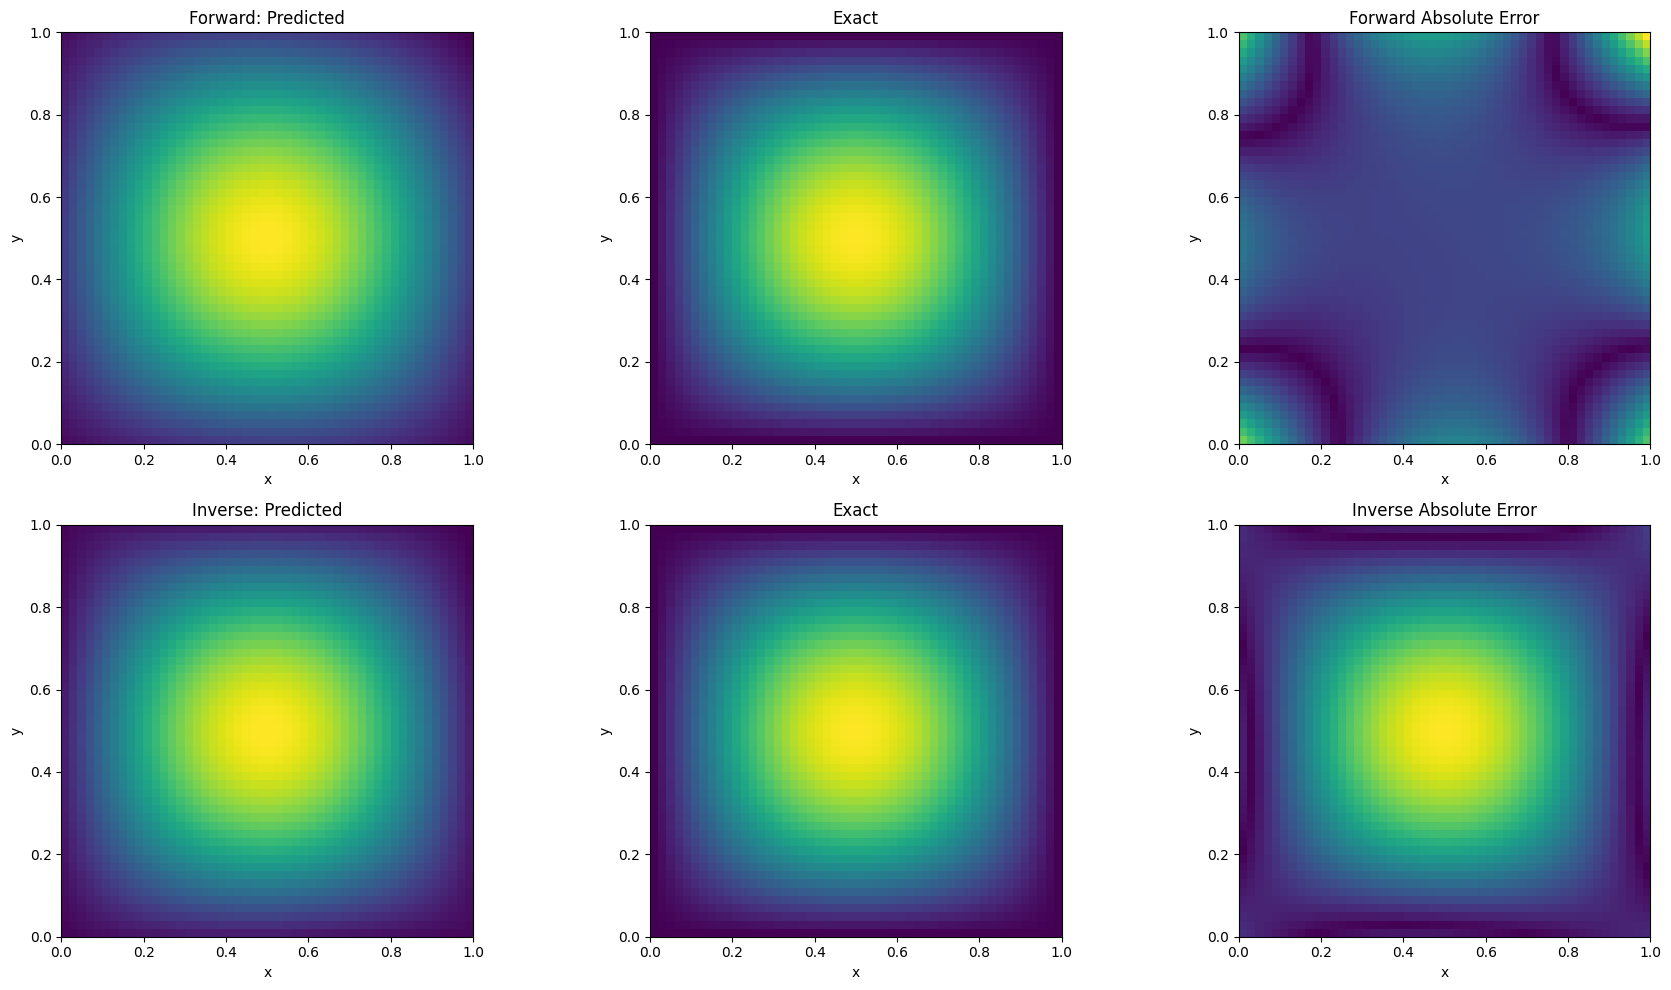

In [ ]:
u_pred_forward_np = u_pred_forward.numpy().reshape(n_test, n_test)
u_exact_np = u_exact_all.numpy().reshape(n_test, n_test)
u_pred_inverse_np = u_pred_inverse.numpy().reshape(n_test, n_test)

fig, axs = plt.subplots(2,3, figsize=(18,10))

axs[0,0].imshow(u_pred_forward_np, origin='lower', extent=[0,1,0,1])
axs[0,0].set_title("Forward: Predicted")
axs[0,1].imshow(u_exact_np, origin='lower', extent=[0,1,0,1])
axs[0,1].set_title("Exact")
axs[0,2].imshow(np.abs(u_pred_forward_np - u_exact_np), origin='lower', extent=[0,1,0,1])
axs[0,2].set_title("Forward Absolute Error")

axs[1,0].imshow(u_pred_inverse_np, origin='lower', extent=[0,1,0,1])
axs[1,0].set_title("Inverse: Predicted")
axs[1,1].imshow(u_exact_np, origin='lower', extent=[0,1,0,1])
axs[1,1].set_title("Exact")
axs[1,2].imshow(np.abs(u_pred_inverse_np - u_exact_np), origin='lower', extent=[0,1,0,1])
axs[1,2].set_title("Inverse Absolute Error")

for ax in axs.flat:
  ax.set_xlabel("x")
  ax.set_ylabel("y")

plt.tight_layout()
plt.show()